# ■COPデータの主軸変換

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline

## ■０．COPデータの読み込みとデータフレームおよびCOP軌跡

※）この notebook はCOPデータと同じフォルダに置くこと。

In [2]:
df = pd.read_csv('2018_0215_1.csv', skiprows=7, header=None)

In [3]:
df = df.iloc[:,0:9]
df.columns=['t','x','y','Lx','Ly','Lweight','Rx','Ry','Rweight']
df.head()

,t,x,y,Lx,Ly,Lweight,Rx,Ry,Rweight
0,0.00,-2.396,0.138,-18.508,-1.126,34.677,17.991,1.736,27.406
1,0.01,-2.411,0.130,-18.516,-1.139,34.716,17.991,1.736,27.406
2,0.02,-2.408,0.149,-18.508,-1.123,34.765,17.987,1.760,27.445
3,0.03,-2.418,0.149,-18.512,-1.116,34.755,17.991,1.754,27.406
4,0.04,-2.423,0.161,-18.512,-1.116,34.755,18.016,1.784,27.357


In [4]:
x = np.array(df['x'])
y = np.array(df['y'])

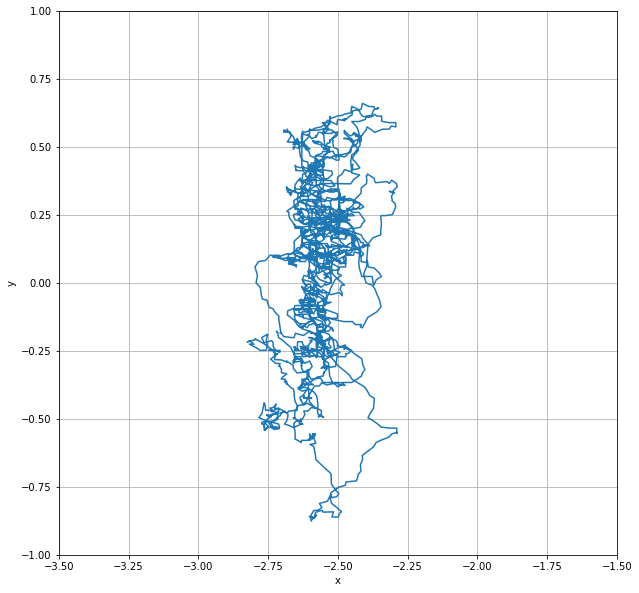

In [5]:
plt.figure(figsize=(10,10))
plt.plot(x, y)
plt.xlim(-3.5,-1.5)
plt.ylim(-1,1)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

## ■１．PCAオブジェクトからデータの共分散行列を求める

データからCOP位置ベクトルをrで定義：

In [6]:
r = np.array([x,y]).T

主成分分析（PCA）クラスから2成分（2変数）PCAオブジェクト（インスタンス）をpcaに生成：

In [7]:
pca = PCA(n_components=2)

pcaオブジェクトにfitメソッドで位置データrを流し込む：

In [8]:
pca.fit(r)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

pcaから共分散行列をAに求める：

In [9]:
A = pca.get_covariance()

In [10]:
A

array([[0.0070834 , 0.00788423],
       [0.00788423, 0.10075524]])

> xの分散が0.0070834，yの分散が0.10075524，共分散が0.00788423。

## ■２．主軸変換（線形代数モジュールを使って）

### ■２−１．主軸変換のための直交変換行列

numpyの線形代数モジュール（numpy.linalg）から，固有値と固有ベクトルを求める関数eigを使って，共分散行列Aの固有値e_val（２つ）とそれぞれの固有値に属する固有ベクトルe_vecを求める（結果はタプルで与えられるようである）：

In [11]:
e_val, e_vec = np.linalg.eig(A)

ちなみに固有値e_valは：

In [12]:
e_val

array([0.00642444, 0.10141421])

> つまり，e_val[0]=0.00642444とe_val[1]=0.10141421。

それぞれの固有値に属する２組の固有ベクトルから構成されるe_vec（行列で与えられる）は：

In [13]:
e_vec

array([[-0.99652533, -0.08329022],
       [ 0.08329022, -0.99652533]])

つまり固有値e_val[0]=0.00642444に属する固有ベクトルは**e_vec.T[0]=[-0.99652533, 0.08329022]**，固有値e_val[1]=0.10141421に属する固有ベクトルは**e_vec.T[1]=[-0.08329022, -0.99652533]**で，それぞれ固有ベクトルが，主軸の**とりあえず**の基本ベクトルということになる。  
> ※注意１：それぞれの固有ベクトルはe_vec行列の列ベクトルで与えれている。  
※注意２：「**とりあえず**」というのは，（後でのべるように）主軸基本ベクトルの取り方が４通りの可能性があり，numpy.linalg.eig関数はそのうちの１つを勝手に選んでいるということだ。

※余談）固有ベクトルから構成される行列e_valは，実は(特殊)直交変換行列（つまり座標系の回転変換行列）を作っている（特殊の意味は座標系の反転は含まない＝回転のみという意味で，行列式が常に1になることが知られている）。直交行列はそれの転置行列をかけたものが単位行列になり，行列式は1である。確かめてみる：

In [14]:
e_vec.T@e_vec

array([[ 1.00000000e+00, -1.38777878e-17],
       [-1.38777878e-17,  1.00000000e+00]])

In [15]:
np.linalg.det(e_vec)

1.0

> 確かにe_vecは(特殊)直交変換行列だ。

行列e_vecによって，共分散行列Aを**対角化**できる：

In [16]:
e_vec.T@A@e_vec

array([[ 6.42443524e-03, -2.16840434e-18],
       [ 0.00000000e+00,  1.01414207e-01]])

上の行列の対角成分（[0,0]成分と[1,1]成分）には，Aの固有値が位置し，それ以外の非対角成分は（事実上）0である。このようにAが変換されたとき，Aは**対角化**されたという。つまり，A（の固有値に属するそれぞれ）の固有ベクトルから構成される直交変換行列によって，Aは対角化される。  

直交変換によって共分散行列Aが対角化できるということは，COP軌跡の**共分散が0**になるような座標軸が存在するということだ。そのような座標軸をCOP軌跡の**主軸**という。

### ■２−２．座標軸の平行移動

計測COPデータのすべての点の中心をどこにするかを決めよう。データ点がある物体を形作る粒子であると考え，粒子の質量はすべて同じであるとする。そうすると，物体の重心は，すべての粒子のx成分の平均の座標と，y成分の平均の座標からなる。例えば，三角形の場合（頂点に同質量の粒子があると思えばよい），その３つの頂点のx成分の平均の座標と，y成分の平均の座標の平均の点が重心である（ことは知っているだろ？）。COPデータの場合も，COPの全ての点について，のx成分の平均の座標と，y成分の平均の座標の平均の点が重心をであり，これをCOP軌跡の中心ととらえるのが合理的だ。そうすることにしよう。

さて，計測COPデータrのx成分の平均とy成分の平均（つまりCOP軌跡の中心）が原点Oになるように，データ数平面の座標を平行移動し，結果としてのデータのr0とする。今の場合，rの各成分の平均はpcaオブジェクトの`mean_`属性で求めることができる。すなわち，

In [17]:
pca.mean_

array([-2.56455182,  0.06659147])

なので，**平行移動: r → r0** は

In [18]:
r0 = r - pca.mean_

である。ここで，rとr0を１つのグラフにプロットしてみる：

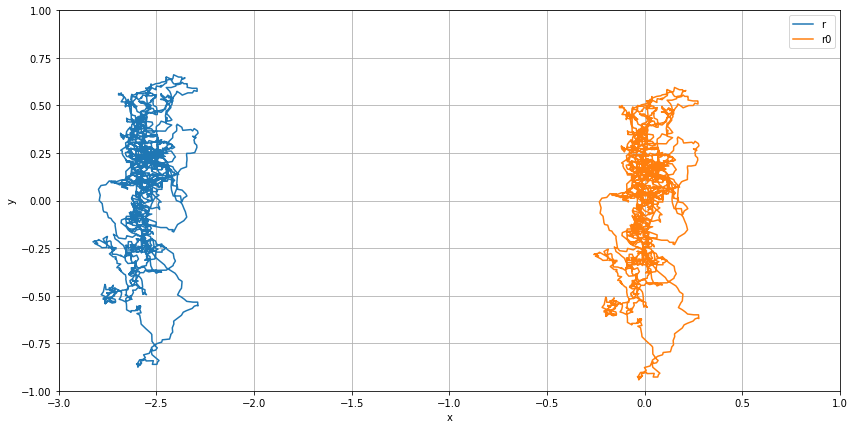

In [19]:
plt.figure(figsize=(14,7))
plt.plot(x, y)
plt.plot(r0.T[0], r0.T[1])
plt.xlim(-3,1)
plt.ylim(-1,1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['r','r0'])
plt.grid()
plt.show()

> 青軌跡rからオレンジ軌跡r0に（ほとんど右に）平行移動された（実際には原点がほとんど左に移動した）ということだ。

### ■２−３．COP軌跡の主軸

直交変換行列e_vecで，r0の数平面の座標軸を回転させ，新しい座標軸における（変換後の）データをqとする。そのとき，**直交変換: r0 → q** は

In [20]:
q = r0@e_vec

qの共分散行列を確かめてみるために，PCAクラスからpca_of_qオブジェクトを生成し，直交変換後の位置データqをpca_of_qに流しこむ：

In [21]:
pca_of_q = PCA(n_components=2)
pca_of_q.fit(q)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

qの共分散行列は：

In [22]:
pca_of_q.get_covariance()

array([[0.00642444, 0.        ],
       [0.        , 0.10141421]])

たしかに，qの共分散は0，つまり上の**直交変換後のCOP軌跡qは（いずれかの）座標軸に沿っている**。つまり，この座標軸がCOP軌跡の（１つの）**主軸**だ。

さて，r0とqを１つのグラフにプロットしてみよう：

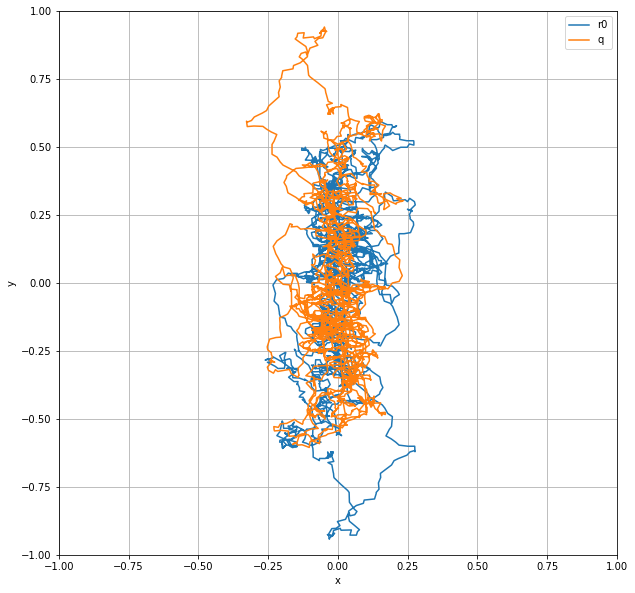

In [23]:
plt.figure(figsize=(10,10))
plt.plot(r0.T[0], r0.T[1])
plt.plot(q.T[0], q.T[1])
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['r0','q'])
plt.grid()
plt.show()

> 上の直交変換によって，COP青軌跡r0がCOPオレンジ軌跡qに時計回り（正確にいうとx軸とy軸が反時計回り）に回転し，**オレンジCOP軌跡qが（ある）主軸に沿った**，ということだ。

上のグラフは，おおかた180°に回転した（COP軌跡としては前後が反転している）ので，r0とqの角の差がわかりにくい。座標系を回転させすぎなのである。これは，主軸変換に伴う回転角の曖昧さによる。  

### ■２−４．主軸の回転

数平面（２次元）における主軸変換理論では，変換によって得られる主軸をただ１つに決めることはできず，**ある１つの主軸に対して，90°，180°，270°回転の曖昧さがある（つまり４通りの曖昧さがある）**のだ。これは，i)（固有値方程式から）固有ベクトルを求める際に，正負の曖昧さがある，ii)２つ固有値に属するそれぞれの固有ベクトルから直交変換行列を作る際に，どちらの固有値を第１固有値と第２固有値とするのかで，直交変換行列の成分が異なってくるという曖昧さがある，ということに起因する。
> 上の例で具体的に述べると，主軸変換行列（主軸基本ベクトルの組み）は  
> ① e_vec
```
e_vec  
array([[-0.99652533, -0.08329022],
       [ 0.08329022, -0.99652533]])
```
② e_vecの**符号を反転**した：  
→ e_vecの反時計回り180°回転 ＝ COP軌跡の時計回り180°回転
```
-e_vec  
array([[ 0.99652533,  0.08329022],
       [-0.08329022,  0.99652533]])
```
③ e_vecの**列ベクトルの順序を入れ替え，第１列ベクトルの符号を反転**した  
→ e_vecの反時計回り90°座標軸回転 ＝ COP軌跡の時計回り90°回転
```
e_vec@np.array([[0, -1], [1, 0]])  
array([[-0.08329022,  0.99652533],
       [-0.99652533, -0.08329022]])
```
>> ※）e_vecの列ベクトルの順序を入れ替えただけでは，そ行列式が-1になるのでダメ！  

> ④ e_vecの**符号を反転し，列ベクトルの順序を入れ替え，第１列ベクトルの符号を反転**をした  
→ e_vecの反時計回り270°回転 ＝ COP軌跡の時計回り270°回転
```
-e_vec@np.array([[0, -1], [1, 0]])  
array([[0.08329022, -0.99652533],
       [0.99652533,  0.08329022]])
```
の４通りのうち，どれをとってもよい。  

したがって，上のオレンジのq軌跡（の座標軸）を，さらに（②の）180°回転しても構わない。それをq0としよう：

In [24]:
q0 = -q

r0とq0を１つのグラフにプロットしてみる：

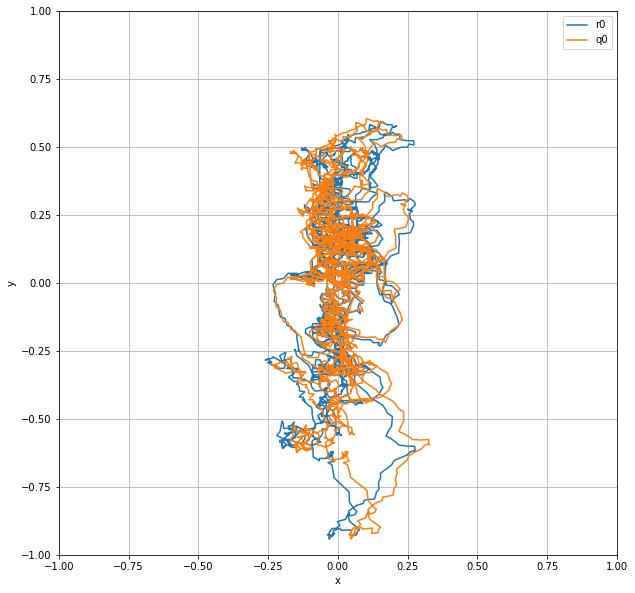

In [25]:
plt.figure(figsize=(10,10))
plt.plot(r0.T[0], r0.T[1])
plt.plot(q0.T[0], q0.T[1])
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['r0','q0'])
plt.grid()
plt.show()

> オレンジのq0は青のr0から，反時計回りにわずかながら回転している。いいかえれば，q0の数平面座標軸は，r0の数平面座標軸から時計回りにわずかながら回転している。その（座標軸の）回転角度は時計回りに：

In [26]:
np.degrees(np.pi - np.arccos(e_vec[0,0]))

4.777713063352856

> およそ4.8°である。

上のグラフの数平面は，q0（オレンジ軌跡）の座標系である。つまり，この数平面でCOPデータ（q0：オレンジ軌跡）の共分散がゼロになり，**COP軌跡（q0：オレンジ軌跡）はy軸に沿い，y軸正方向が前，y軸負方向が後，**と決定できる。 

こんどは，q0の座標軸を（③の）90°回転してq1とし，q0とq1のグラフを描いてみよう：

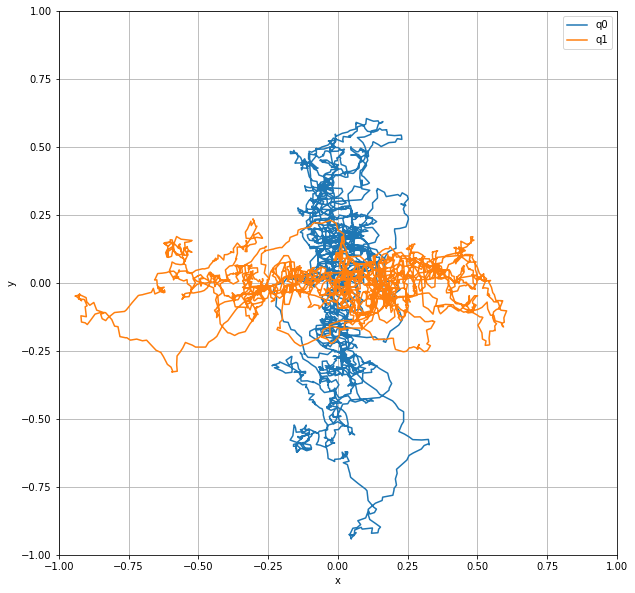

In [27]:
q1 = q0@np.array([[0, -1], [1, 0]])
plt.figure(figsize=(10,10))
plt.plot(q0.T[0], q0.T[1])
plt.plot(q1.T[0], q1.T[1])
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['q0','q1'])
plt.grid()
plt.show()

**オレンジのq1軌跡**が，われわれの目的とする，**x軸に沿ったCOPの軌跡**ということになる。

※）ただし，ここまでのやりかたは非常に面倒くさい（だからプログラムも複雑になる）し，せっかくのPCAオブジェクトを生かしていない。ただ「**主軸変換というのはこういうもんだよ**」ということを示したかったんだ。

## ■３．PCAオブジェクトのtransformメソッドで主軸変換

### ■３－１．transformメソッドによる主軸変換

PCAオブジェクトのpcaを生成してCOP計測データrを流し込むと，実はオブジェクトpcaの属性として，rの共分散行列Aの固有値や固有ベクトルは属性（プロパティ）として既にできあがっている。だからほんとうは，線形代数モジュールを使わなくてもよかったんだ。  

共分散行列Aの**固有値**は，pcaオブジェクトの**`explained_variance_`**属性にある：

In [28]:
pca.explained_variance_

array([0.10141421, 0.00642444])

共分散行列Aのそれぞれの固有値に属する固有ベクトルは，pcaオブジェクトの**```components_```**属性にある：

In [29]:
pca.components_

array([[-0.08329022, -0.99652533],
       [ 0.99652533, -0.08329022]])

ただし，pca.components_行列を構成するそれぞれの固有ベクトルは，（e_vecのように列ベクトルではなく）その行列の行ベクトルである。つまり，固有値`pca.explained_variance_[0]=0.10141421`に属する固有ベクトルは，`pca.components_[0]=[-0.08329022, -0.99652533]`，固有値`pca.explained_variance_[1]=0.10141421`に属する固有ベクトルは，`pca.components_[1]=[ 0.99652533, -0.08329022]`である。  

`pca.components_`行列によって，共分散行列Aが対角化される確かめよう：

In [30]:
pca.components_@A@(pca.components_.T)

array([[ 1.01414207e-01, -1.73472348e-18],
       [-1.19262239e-18,  6.42443524e-03]])

> `pca.components_`行列によって，Aは確かに対角化される。

計測データのCOP軌跡は，オブジェクトpcaにtransform(r)メソッドを作用させることで一挙に主軸変換（座標軸の平行移動と回転）できる。主軸変換されたCOP軌跡をr1とする：

In [31]:
r1 = pca.transform(r)

元のCOP軌跡（青）rと主軸変換後のCOP軌跡（オレンジ）r1のグラフを描いてみる：

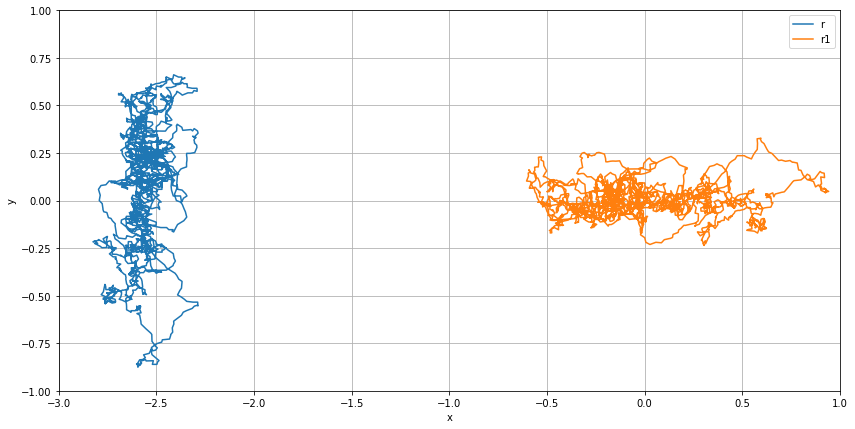

In [32]:
plt.figure(figsize=(14,7))
plt.plot(r.T[0], r.T[1])
plt.plot(r1.T[0], r1.T[1])
plt.xlim(-3,1)
plt.ylim(-1,1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['r','r1'])
plt.grid()
plt.show()

> おしい！ オレンジ軌跡（r1）は，前後がひっくり返っている。

PCAのtransformメソッドは，**分散の大きい方を第１主軸（x軸）**に，小さい方を第２主軸にとるようになっており（これは主成分分析によって，主軸がそうなるように定義させているからである），このことはわれわれの目的に沿っている。しかしながら**分散には方向がない**ので，データをCOP軌跡としてみたときには，必ずしも前後方向がきちっと決まらない（上の場合，前後が逆転している）。  

### ■３－２．最終的な主軸変換（COP軌跡の前後方向の決定）

われわれの計測COPデータは，ほぼ**y軸を前後方向**で，**y軸正方向をほぼ前方向**と想定して計測したものだということを思い起こそう。したがって，計測COPデータは必ず**ほぼy軸方向に大きい方の分散**が広がる。一方，CPAでは，上に述べたように**分散の大きい方を第１主軸（x軸）**とする。したがって，計測COPの座標データ**rの数平面**で，**主軸変換後に第１主軸（x軸）となるべく基本ベクトルのy成分**が**正**のとき変換後に**COP軌跡は前方向がxの正方向**，逆に**主軸変換後に第１主軸（x軸）となるべく基本ベクトルのy成分**が**負**のとき変換後に**COP軌跡は前方向がxの負方向**を向くだろう。したがって，主軸変換後のr1は次のように訂正されるべきである：

In [33]:
if pca.components_[0,1] < 0:
    r1 = -pca.transform(r)
else:
    r1 = pca.transform(r)

この**主軸変換: r → r1** をグラフにすると：

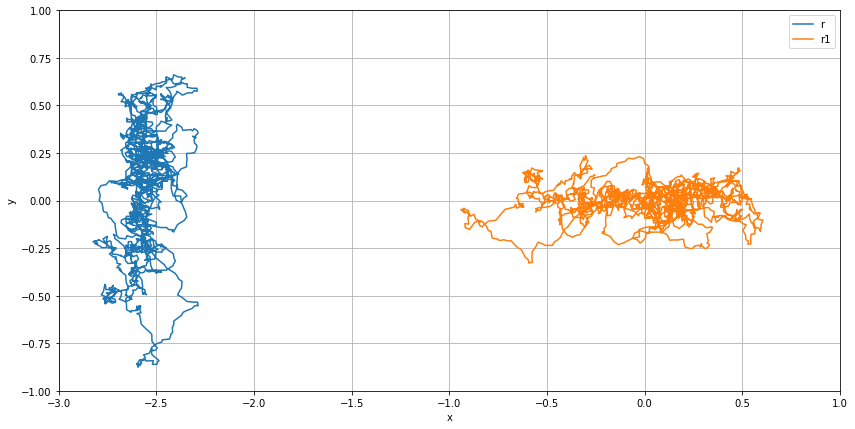

In [34]:
plt.figure(figsize=(14,7))
plt.plot(r.T[0], r.T[1])
plt.plot(r1.T[0], r1.T[1])
plt.xlim(-3,1)
plt.ylim(-1,1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['r','r1'])
plt.grid()
plt.show()

> r1（オレンジ軌跡）が求めるべきCOP軌跡ということになる。

目的の主軸変換後の**r1軌跡**をもう一度（青で）描いてみる：

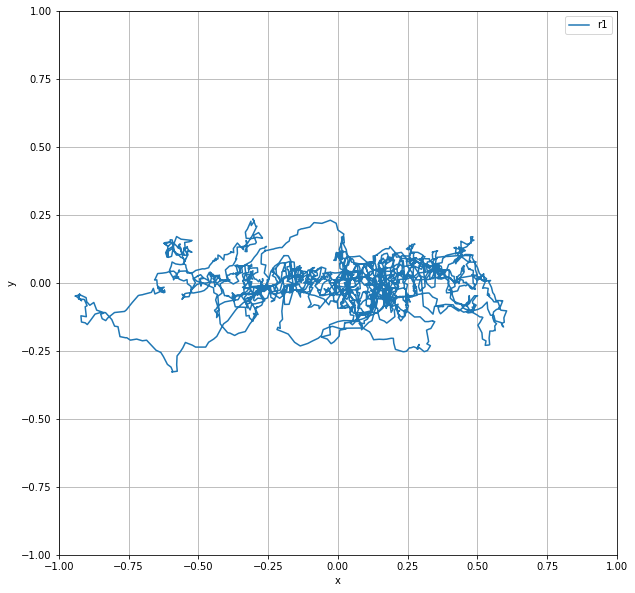

In [35]:
plt.figure(figsize=(10,10))
plt.plot(r1.T[0], r1.T[1])
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['r1'])
plt.grid()
plt.show()

主軸変換後のCOP軌跡が，ほんとうに主軸に沿っているかを確かめよう。これは，r1の共分散行列が対角行列（共分散が0）であればよい。まず，r1からPCAオブジェクトを生成して：

In [36]:
pca_of_r1 = PCA(n_components=2)
pca_of_r1.fit(r1)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

そのときr1の共分散行列は，

In [37]:
pca_of_r1.get_covariance()

array([[0.10141421, 0.        ],
       [0.        , 0.00642444]])

### ３−３．寄与率

主成分分析における**寄与率**というのは，（主軸変換された）データがどの程度主軸に寄与しているかの目安である。われわれの場合，主軸変換後のCOP軌跡を構成している点のx座標とy座標が，全体でどの程度の割合でx軸とy軸のそれぞれに寄与しているかということを知りたい。そして，もし（主軸変換後の）COPデータ点全体のx座標への寄与の割合が非常に大きくて，y座標への寄与の割合が非常に小さければ，近似的に１次元運動をしているとみなせるであろう。  

データの第*i*主軸への寄与率は，$\frac{固有値i}{固有値の総和}$で求めることができる。すでに固有値がわかっているので，この計算式に各固有値を代入して計算すればよいのだが，PCAオブジェクトには寄与率に対する**`explained_variance_ratio_`**属性があるので，それを用いることにする：

In [38]:
pca.explained_variance_ratio_

array([0.94042548, 0.05957452])

つまり上のCOP軌跡の全ての点について，（主軸）x軸への（x座標の）寄与はおよそ94%，（主軸）y軸への（y座標の）寄与はおよそ6%ということだ。この寄与率によって次元削減（dimensional reduction），つまり開脚立位時のCOP動揺が，x軸のみの一次元運動とみなせるかどうかの判定の目安になるであろう。

ちなみに，上の（主軸変換後）のCOP動揺（r1）のx軸方向とy軸方向の時系列ブラフは以下のように描かれる：

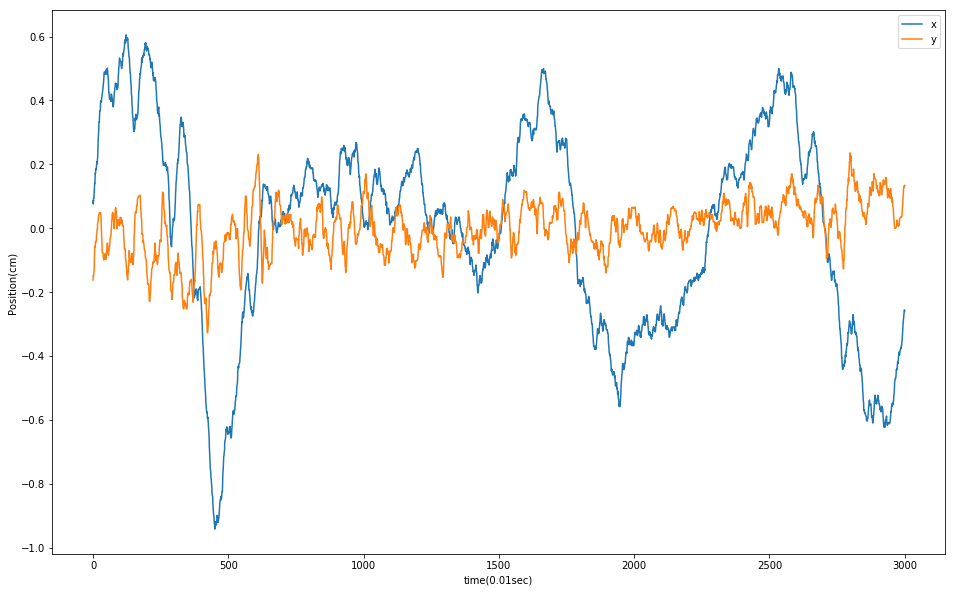

In [39]:
plt.figure(figsize=(16,10))
plt.plot(r1.T[0])
plt.plot(r1.T[1])
plt.xlabel('time(0.01sec)')
plt.ylabel('Position(cm)')
plt.legend(['x','y'])
plt.show()

### ３−４．主軸変換の前と後でのCOP矩形面積の異なり

主軸変換前のCOP軌跡の矩形面積と主軸変換後のCOP軌跡の矩形面積の数値的差異を調べてみる。

主軸変換前のCOPデータはrであった。rの最大x座標と最小x座標の差，および最大y座標と最小y座標の差の組みrange_rは，

In [40]:
range_r = np.max(r, axis=0)-np.min(r, axis=0)
range_r

array([0.538, 1.537])

したがって，COP軌跡rの矩形面積S_rは，

In [41]:
S_r = range_r[0]*range_r[1]
S_r

0.8269060000000004

一方，主軸変換後のCOPデータはr1で，r1の最大x座標と最小x座標の差，および最大y座標と最小y座標の差の組みrange_r1は，

In [42]:
range_r1 = np.max(r1, axis=0)-np.min(r1, axis=0)
range_r1

array([1.54690155, 0.56320291])

したがって，COP軌跡r1の矩形面積S_r1は，

In [43]:
S_r1 = range_r1[0]*range_r1[1]
S_r1

0.8712194499798388

矩形面積S_r1と矩形面積S_rの差は，

In [44]:
S_r1 - S_r

0.04431344997983844

この差が大きいとみるか小さいとみるかは別の話だ。重要なのは，**座標軸の取り方によって矩形面積が異なってしまう**ということだ。